SENTIMENT ANALYSIS ON IMDB REVIEWS - AWD-LSTM model using ULMFiT methodology

In [ ]:
## Import all necessary libraries
import fastai
from fastai import *
from fastai.text import *
from fastai.text.all import *
import huggingface_hub
import datasets
from datasets import load_dataset
from fastai.text.all import TextDataLoaders
import re
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import string
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("✅ All libraries imported successfully!")
print("📊 Pandas version:", pd.__version__)
print("🔤 FastAI version:", fastai.__version__)

✅ All libraries imported successfully!
📊 Pandas version: 2.2.2
🔤 FastAI version: 2.8.6


LOADING THE IMDB DATASET

In [ ]:
## load dataset from stanford ai
dataset = load_dataset("imdb")
df = pd.DataFrame(dataset["train"])
df.head()

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

,text,label
0,"I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered ""controversial"" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain politica...",0
1,"""I Am Curious: Yellow"" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn't true. I've seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don't exist. The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight. And those pretentious indie movies li...",0
2,"If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />",0
3,"This film was probably inspired by Godard's Masculin, féminin and I urge you to see that film instead.<br /><br />The film has two strong elements and those are, (1) the realistic acting (2) the impressive, undeservedly good, photo. Apart from that, what strikes me most is the endless stream of silliness. Lena Nyman has to be most annoying actress in the world. She acts so stupid and with all the nudity in this film,...it's unattractive. Comparing to Godard's film, intellectuality has been replaced with stupidity. Without going too far on this subject, I would say that follows from the dif...",0
4,"Oh, brother...after hearing about this ridiculous film for umpteen years all I can think of is that old Peggy Lee song..<br /><br />""Is that all there is??"" ...I was just an early teen when this smoked fish hit the U.S. I was too young to get in the theater (although I did manage to sneak into ""Goodbye Columbus""). Then a screening at a local film museum beckoned - Finally I could see this film, except now I was as old as my parents were when they schlepped to see it!!<br /><br />The ONLY reason this film was not condemned to the anonymous sands of time was because of the obscenity case spa...",0


FINE-TUNING THE MODEL BASED ON AWD-LSTM using ULMFIT METHODOLOGY

In [ ]:
## Finetune
dls = TextDataLoaders.from_df(df, text_col="text", label_col="label", valid_pct=0.2)
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

Finding the optimal learning rate for training the AWD-LSTM sentiment analysis model which helps in setting an effective learning rate for training. Using lr_find() method to find learning rate.

SuggestedLRs(valley=0.002511886414140463)

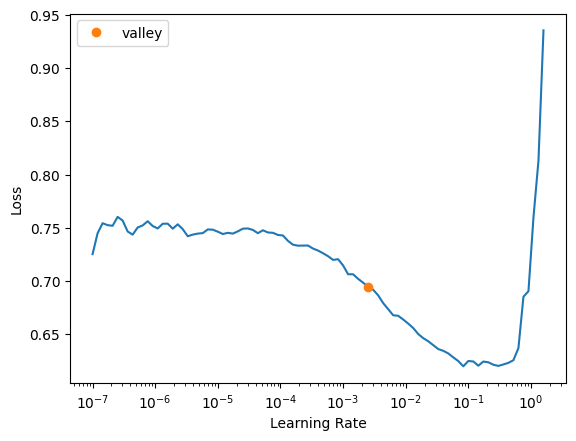

In [ ]:
learn.lr_find()

Training the classification head of the AWD-LSTM model while keeping the pre-trained language model layers frozen. This initial training helps in adapting the classifier to the sentiment analysis task. Using `fit_one_cycle()` with the optimal learning rate determined in the earlier step. Freeze the model layers to train the classifier head so that weights are not updated


In [ ]:
learn.freeze()
print("✅ Model layers frozen successfully.")

✅ Model layers frozen successfully.


Training the classifier head for 1 epoch using the optimal learning rate (0.002089).



In [ ]:
learn.fit_one_cycle(1, 0.002089)
print("✅ Classifier head trained successfully for 1 epoch.")

epoch,train_loss,valid_loss,accuracy,time
0,0.464019,0.388803,0.832200,01:49


✅ Classifier head trained successfully for 1 epoch.


Unfreeze the model layers and fine-tune it. To do so, using learn.freeze_to() for stage-wise fine-tuning.


In [ ]:
learn.freeze_to(-2)
print("✅ Last two layers of the model unfrozen.")

✅ Last two layers of the model unfrozen.


I will now train the unfrozen layers for 1 epoch using discriminative learning rates, as per the ULMFiT methodology.



In [ ]:
learn.fit_one_cycle(1, slice(1e-3/2.6, 1e-3))
print("✅ Unfrozen layers trained for 1 epoch with discriminative learning rates.")

epoch,train_loss,valid_loss,accuracy,time
0,0.390391,0.330356,0.860800,02:17


✅ Unfrozen layers trained for 1 epoch with discriminative learning rates.


Preparing for fine-tuning the entire model, unfreezing all layers using learn.unfreeze()



In [ ]:
learn.unfreeze()
print("✅ Entire model unfrozen.")

✅ Entire model unfrozen.


Fine-tuning it for 5 epochs using discriminative learning rates



In [ ]:
learn.fit_one_cycle(5, slice(1e-4, 1e-3))
print("✅ Entire model fine-tuned for 5 epochs with discriminative learning rates.")

epoch,train_loss,valid_loss,accuracy,time
0,0.313074,0.265542,0.892200,05:06
1,0.265307,0.227647,0.908600,05:05
2,0.206441,0.200809,0.920800,05:06
3,0.169227,0.198928,0.926400,05:06
4,0.147205,0.199884,0.926000,05:06


✅ Entire model fine-tuned for 5 epochs with discriminative learning rates.


Evaluating Model Performance using validate() to get validation loss and accuracy as output


In [ ]:
loss, acc = learn.validate()
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

Validation Loss: 0.1999
Validation Accuracy: 0.9260


Saving the trained AWD-LSTM sentiment analysis model

In [ ]:
learn.export('fine_tuned_awd_lstm.pkl')
print("✅ Trained model exported successfully as 'fine_tuned_awd_lstm.pkl'.")

✅ Trained model exported successfully as 'fine_tuned_awd_lstm.pkl'.


Predicting the sentiment, after loading the saved model using load_learner(), defining a function that takes raw text, preprocessing it, and using the loaded model to make a prediction. Testing the function with an example review.

In [ ]:
from fastai.text.all import *

# Load the saved model
learn = load_learner('fine_tuned_awd_lstm.pkl')
print("✅ Model loaded successfully.")

def predict_sentiment(text):
    """Predicts the sentiment of a given text using the fine-tuned model."""
    # FastAI's predict method handles preprocessing (tokenization, numericalization) automatically
    # It returns prediction, sentiment index, and probabilities
    prediction, pred_idx, probabilities = learn.predict(text)

    sentiment = 'Positive' if prediction == '1' else 'Negative'
    confidence = probabilities[pred_idx].item() * 100

    return sentiment, confidence

# Example usage
example_review = "This movie was absolutely fantastic! I loved every moment of it."
sentiment, confidence = predict_sentiment(example_review)
print(f"\nReview: {example_review}")
print(f"Predicted Sentiment: {sentiment} (Confidence: {confidence:.2f}%) ")

example_review_negative = "The film was terrible, a complete waste of time. I disliked it immensely."
sentiment, confidence = predict_sentiment(example_review_negative)
print(f"\nReview: {example_review_negative}")
print(f"Predicted Sentiment: {sentiment} (Confidence: {confidence:.2f}%) ")

✅ Model loaded successfully.



Review: This movie was absolutely fantastic! I loved every moment of it.
Predicted Sentiment: Positive (Confidence: 99.99%) 



Review: The film was terrible, a complete waste of time. I disliked it immensely.
Predicted Sentiment: Negative (Confidence: 100.00%) 
